## Time Series Classification and Clustering  

- Reference:  https://github.com/alexminnaar/time-series-classification-and-clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

% matplotlib inline

### test data set

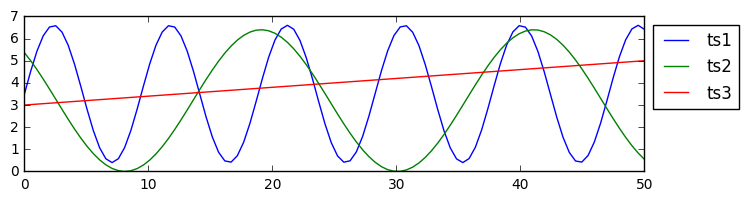

In [2]:
x = np.linspace(0, 50, 100)
ts1 = 3.1 * np.sin(x/1.5) + 3.5
ts2 = 3.2 * np.sin(x/3.5+2.4) + 3.2
ts3 = 0.04*x + 3.0

plt.figure(figsize=(8,2))
plt.plot(x, ts1, label = "ts1")
plt.plot(x, ts2, label = "ts2")
plt.plot(x, ts3, label = "ts3")
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

### Distance Function

In [3]:
## Euclidean distance
def euclideanDist(ts1, ts2):
    return np.sqrt(sum((ts1 - ts2)**2))

## Complexity - O(nm)
def DTWDist(ts1, ts2):
    len1 = len(ts1)
    len2 = len(ts2)
    
    # dp[i,j] indicate the length of subsequence of ts1 and ts2 from start
    dp = np.zeros((len1+1, len2+1), dtype='float')
    dp[0, 0] = 0
    for j in range(1, len2+1):
        dp[0, j] = np.inf
    for i in range(1, len1+1):
        dp[i, 0] = np.inf
    
    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            dp[i,j] = min(dp[i-1, j], dp[i, j-1], dp[i-1, j-1]) + (ts1[i-1] - ts2[j-1])**2
    
    return np.sqrt(dp[len1, len2])

# speed up DTW
# this works under the assumption that it is unlikely for qi and cj to be matched if i and j are too far apart
# The threshold is determined by a window size 'win'
# speed up the inner loop
def DTWDistSpeeded(ts1, ts2, win):
    len1 = len(ts1)
    len2 = len(ts2)
    
    win = max(win, abs(len1 - len2)) # the second item is the length of tail
    dp = np.zeros((len1+1, len2+1)) + np.inf
    dp[0,0] = 0
    for i in range(1, len1+1):
        for j in range(max(1, i-win), min(len2+1, i + win) ):  # speeded up
            dist = (ts1[i-1] - ts2[j-1])**2
            dp[i][j] = dist + min(dp[i-1, j-1], dp[i-1, j], dp[i, j-1])
    
    return np.sqrt(dp[len1, len2])

# complexity: O(n)
def LBKeogh(ts1, ts2, r):
    LBSum = 0
    for ind, value in enumerate(ts1):
        lowerBound = min(ts2[( ind - r if ind >= r else 0 ):( ind+r)])
        upperBound = max(ts2[( ind - r if ind >= r else 0):(ind+r)])
        
        if value > upperBound:
            LBSum = LBSum + (value-upperBound)**2
        elif value < lowerBound:
            LBSum = LBSum + (value-lowerBound)**2
        
    return np.sqrt(LBSum)

In [4]:
print(euclideanDist(ts1, ts2))
print(euclideanDist(ts1, ts3))
print(euclideanDist(ts2, ts3))

31.2863246196
23.1892491903
23.2456780845


In [5]:
print(DTWDist(ts1, ts2))
print(DTWDist(ts1, ts3))
print(DTWDist(ts2, ts3))

18.2515620232
21.5494948244
20.8777161937


In [6]:
print(DTWDistSpeeded(ts1, ts2, 10))
print(DTWDistSpeeded(ts1, ts3, 10))
print(DTWDistSpeeded(ts2, ts3, 10))

19.4094249393
22.4724828468
22.0138750686


In [7]:
print(LBKeogh(ts1, ts2, 20))
print(LBKeogh(ts1, ts3, 20))
print(LBKeogh(ts2, ts3, 20))

2.17709650716
19.9595478694
20.0879949094


### Classification - KNN

In [8]:
from sklearn.metrics import classification_report

def KNNClassify(trainArr, trainY, testArr, testY, k, distFunc, *distFuncArgs):
    import operator
    k = min(len(trainArr), k)
    predList = []
    for ind, vecTest in enumerate(testArr):
        distList = []
        for  vecTrain in trainArr:
            dist = distFunc(vecTest, vecTrain, *distFuncArgs)
            distList.append(dist)
        sortedIndexs = np.argsort(distList)
        predDic = {}
        for i in range(k):
            voteLabel = trainY[sortedIndexs[i]]
            predDic[voteLabel] = predDic.get(voteLabel, 0) + 1
        
        sortedClassCount = sorted(predDic.items(), key = operator.itemgetter(1), reverse = True)
        predList.append(sortedClassCount[0][0])
        
    return classification_report(testY, predList)

In [13]:
startTime = time.time()
DATA_ROOT = "time-series-classification-and-clustering/datasets/"
originalTrainArr = np.genfromtxt(DATA_ROOT + 'train.csv', delimiter='\t', dtype='float')
originalTestArr = np.genfromtxt(DATA_ROOT + 'test.csv', delimiter='\t', dtype='float')
trainArr = originalTrainArr[:,:-1]
testArr = originalTestArr[:,:-1]
trainY = originalTrainArr[:,-1]
testY = originalTestArr[:,-1]
print(trainArr.shape)
print("class: ", np.unique(np.vstack((trainY,testY))))
print(KNNClassify(trainArr, trainY, testArr, testY, 1, DTWDistSpeeded, (50)))
endTime = time.time()
print "used time is ", endTime - startTime

(300, 60)
('class: ', array([ 1.,  2.,  3.,  4.,  5.,  6.]))
             precision    recall  f1-score   support

        1.0       1.00      0.96      0.98        50
        2.0       0.98      1.00      0.99        50
        3.0       1.00      1.00      1.00        50
        4.0       1.00      1.00      1.00        50
        5.0       0.98      1.00      0.99        50
        6.0       1.00      1.00      1.00        50

avg / total       0.99      0.99      0.99       300

used time is  622.104526997


### Classification - KNN-Parallel with multiprocessing Pool

In [13]:
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool 

def KNNClassifyParallel(trainArr, trainY, testArr, testY, k, nJobs,distFunc, *distFuncArgs):
    import operator
    k = min(len(trainArr), k)
    predList = []
    pool = ThreadPool(nJobs) 
    for ind, vecTest in enumerate(testArr):
        distList = []
        distList = pool.map(lambda vecTrain:distFunc(vecTest, vecTrain, *distFuncArgs), trainArr)
        sortedIndexs = np.argsort(distList)
        predDic = {}
        for i in range(k):
            voteLabel = trainY[sortedIndexs[i]]
            predDic[voteLabel] = predDic.get(voteLabel, 0) + 1
        
        sortedClassCount = sorted(predDic.items(), key = operator.itemgetter(1), reverse = True)
        predList.append(sortedClassCount[0][0])
    pool.close() 
    pool.join()  
    return classification_report(testY, predList)

In [15]:
startTime = time.time()
DATA_ROOT = "time-series-classification-and-clustering/datasets/"
originalTrainArr = np.genfromtxt(DATA_ROOT + 'train.csv', delimiter='\t', dtype='float')
originalTestArr = np.genfromtxt(DATA_ROOT + 'test.csv', delimiter='\t', dtype='float')
trainArr = originalTrainArr[:,:-1]
testArr = originalTestArr[:,:-1]
trainY = originalTrainArr[:,-1]
testY = originalTestArr[:,-1]
#print(trainArr.shape)
#print("class: ", np.unique(np.vstack((trainY,testY))))
#win = int(len(trainArr)*0.2)
win = 50
nJobs = 20
classReport = KNNClassifyParallel(trainArr, trainY, testArr, testY, 1, nJobs, DTWDistSpeeded, (win))
#print(KNNClassifyParallel(trainArr, trainY, testArr, testY, 1, nJobs, euclideanDist))
endTime = time.time()
wastTime = endTime - startTime
print ("used time is ", wastTime)

('used time is ', 912.3796639442444)


In [16]:
startTime = time.time()
DATA_ROOT = "time-series-classification-and-clustering/datasets/"
originalTrainArr = np.genfromtxt(DATA_ROOT + 'train.csv', delimiter='\t', dtype='float')
originalTestArr = np.genfromtxt(DATA_ROOT + 'test.csv', delimiter='\t', dtype='float')
trainArr = originalTrainArr[:,:-1]
testArr = originalTestArr[:,:-1]
trainY = originalTrainArr[:,-1]
testY = originalTestArr[:,-1]
#print(trainArr.shape)
#print("class: ", np.unique(np.vstack((trainY,testY))))
#win = int(len(trainArr)*0.2)
win = 50
nJobs = 5
classReport = KNNClassifyParallel(trainArr, trainY, testArr, testY, 1, nJobs, DTWDistSpeeded, (win))
#print(KNNClassifyParallel(trainArr, trainY, testArr, testY, 1, nJobs, euclideanDist))
endTime = time.time()
wastTime = endTime - startTime
print ("used time is ", wastTime)

('used time is ', 781.8037819862366)


In [17]:
startTime = time.time()
DATA_ROOT = "time-series-classification-and-clustering/datasets/"
originalTrainArr = np.genfromtxt(DATA_ROOT + 'train.csv', delimiter='\t', dtype='float')
originalTestArr = np.genfromtxt(DATA_ROOT + 'test.csv', delimiter='\t', dtype='float')
trainArr = originalTrainArr[:,:-1]
testArr = originalTestArr[:,:-1]
trainY = originalTrainArr[:,-1]
testY = originalTestArr[:,-1]
#print(trainArr.shape)
#print("class: ", np.unique(np.vstack((trainY,testY))))
#win = int(len(trainArr)*0.2)
win = 50
nJobs = 10
classReport = KNNClassifyParallel(trainArr, trainY, testArr, testY, 1, nJobs, DTWDistSpeeded, (win))
#print(KNNClassifyParallel(trainArr, trainY, testArr, testY, 1, nJobs, euclideanDist))
endTime = time.time()
wastTime = endTime - startTime
print ("used time is ", wastTime)

('used time is ', 871.4658410549164)


### Classification - KNN-Parallel with joblib

In [14]:
import joblib

def KNNClassifyParallelJobLib(trainArr, trainY, testArr, testY, k, nJobs,distFunc, *distFuncArgs):
    import operator
    k = min(len(trainArr), k)
    predList = []
    for ind, vecTest in enumerate(testArr):
        distList = []
        distList = joblib.Parallel(n_jobs=nJobs)(joblib.delayed(distFunc)(vecTest, vecTrain, *distFuncArgs) 
                                      for vecTrain in trainArr)
        sortedIndexs = np.argsort(distList)
        predDic = {}
        for i in range(k):
            voteLabel = trainY[sortedIndexs[i]]
            predDic[voteLabel] = predDic.get(voteLabel, 0) + 1
        
        sortedClassCount = sorted(predDic.items(), key = operator.itemgetter(1), reverse = True)
        predList.append(sortedClassCount[0][0])
    return classification_report(testY, predList)

In [15]:
startTime = time.time()
DATA_ROOT = "time-series-classification-and-clustering/datasets/"
originalTrainArr = np.genfromtxt(DATA_ROOT + 'train.csv', delimiter='\t', dtype='float')
originalTestArr = np.genfromtxt(DATA_ROOT + 'test.csv', delimiter='\t', dtype='float')
trainArr = originalTrainArr[:,:-1]
testArr = originalTestArr[:,:-1]
trainY = originalTrainArr[:,-1]
testY = originalTestArr[:,-1]
#print(trainArr.shape)
#print("class: ", np.unique(np.vstack((trainY,testY))))
#win = int(len(trainArr)*0.2)
win = 50
nJobs = 10
classReport = KNNClassifyParallelJobLib(trainArr, trainY, testArr, testY, 1, nJobs, DTWDistSpeeded, (win))
print(classReport)
endTime = time.time()
wastTime = endTime - startTime
print ("used time is ", wastTime)

             precision    recall  f1-score   support

        1.0       1.00      0.96      0.98        50
        2.0       0.98      1.00      0.99        50
        3.0       1.00      1.00      1.00        50
        4.0       1.00      1.00      1.00        50
        5.0       0.98      1.00      0.99        50
        6.0       1.00      1.00      1.00        50

avg / total       0.99      0.99      0.99       300

('used time is ', 146.00371479988098)


In [16]:
startTime = time.time()
DATA_ROOT = "time-series-classification-and-clustering/datasets/"
originalTrainArr = np.genfromtxt(DATA_ROOT + 'train.csv', delimiter='\t', dtype='float')
originalTestArr = np.genfromtxt(DATA_ROOT + 'test.csv', delimiter='\t', dtype='float')
trainArr = originalTrainArr[:,:-1]
testArr = originalTestArr[:,:-1]
trainY = originalTrainArr[:,-1]
testY = originalTestArr[:,-1]
#print(trainArr.shape)
#print("class: ", np.unique(np.vstack((trainY,testY))))
#win = int(len(trainArr)*0.2)
win = 50
nJobs = 20
classReport = KNNClassifyParallelJobLib(trainArr, trainY, testArr, testY, 1, nJobs, DTWDistSpeeded, (win))
print(classReport)
endTime = time.time()
wastTime = endTime - startTime
print ("used time is ", wastTime)

             precision    recall  f1-score   support

        1.0       1.00      0.96      0.98        50
        2.0       0.98      1.00      0.99        50
        3.0       1.00      1.00      1.00        50
        4.0       1.00      1.00      1.00        50
        5.0       0.98      1.00      0.99        50
        6.0       1.00      1.00      1.00        50

avg / total       0.99      0.99      0.99       300

('used time is ', 159.24618792533875)


### Clustering - KMeans

In [49]:
import random

def KMeansClust(dataArr, numClust, numIter, distFunc, distFuncArgs):
    m,n = dataArr.shape
    print(m, n)
    centoridIndex = np.random.randint(m, size = numClust)
    centorids = dataArr[centoridIndex,:]
    for i in range(numIter):
        print("the %d-th iteration\n" % i)
        clustersDic = {}
        for dInd, dataVec in enumerate(dataArr):
            minDist = np.inf
            closestClust = None
            for cInd, centVec in enumerate(centorids):
                curDist = distFunc(dataVec, centVec, *distFuncArgs)
                if curDist < minDist:
                    minDist = curDist
                    closestClust = cInd
                if closestClust not in clustersDic:
                    clustersDic[closestClust] = []
                clustersDic[closestClust].append(dInd)
                
        # re-calculate centroids of clusters
        for key in clustersDic:
            clustSum = np.zeros((1,n))
            for dInd in clustersDic[key]:
                clustSum += dataArr[dInd]
            centorids[key] = np.array(clustSum) / len(clustersDic[key])
    return centorids

(300, 61)
('class: ', array([ 1.,  2.,  3.,  4.,  5.,  6.]))
(300, 61)
(600, 60)
(600, 60)
the 0-th iteration

the 1-th iteration

the 2-th iteration

the 3-th iteration

the 4-th iteration

the 5-th iteration

the 6-th iteration

the 7-th iteration

the 8-th iteration

the 9-th iteration



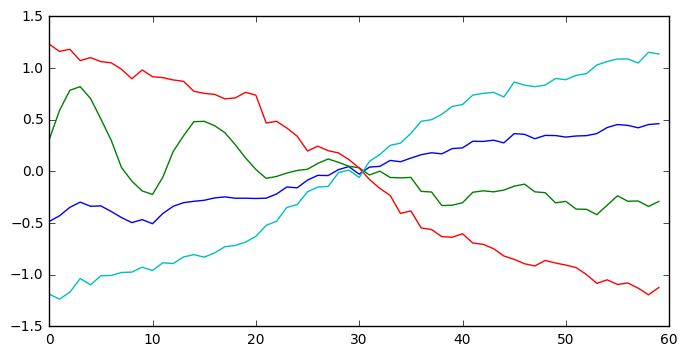

In [50]:
DATA_ROOT = "time-series-classification-and-clustering/datasets/"
trainArr = np.genfromtxt(DATA_ROOT + 'train.csv', delimiter='\t', dtype='float')
testArr = np.genfromtxt(DATA_ROOT + 'test.csv', delimiter='\t', dtype='float')
print(trainArr.shape)
#print("train data:", trainArr[:,0])
print("class: ", np.unique(trainArr[:,-1]))
print(testArr.shape)
#print(testArr)
#print(knn(trainArr, testArr, 4))
dataArr = np.vstack((trainArr[:,:-1], testArr[:,:-1]))
print(dataArr.shape)
centorids = KMeansClust(dataArr, 4, 10, DTWDistSpeeded, (50,))

plt.figure(figsize=(8,4))
for vec in centorids:
    plt.plot(vec)
    
plt.show()

## A real case

In [9]:
path = "../data/UCR_TS_Archive_2015/50words/"
originTrainArr = np.genfromtxt(path + '50words_TRAIN', delimiter = ',', dtype='float')
originTestArr = np.genfromtxt(path + '50words_TEST', delimiter = ',', dtype='float')
print(originTrainArr.shape)
print(originTestArr.shape)

# ajust data set
trainLabelArr = originTrainArr[:, 0]
testLabelArr = originTestArr[:, 0]
trainDataArr = originTrainArr[:, 1::]
testDataArr = originTestArr[:, 1::]

print("class:", np.unique(trainLabelArr))
print(KNNClassify(trainDataArr, trainLabelArr, testDataArr, testLabelArr, 15, DTWDistSpeeded, (50,) ))

(450, 271)
(455, 271)
('class:', array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.]))
             precision    recall  f1-score   support

        1.0       0.62      0.96      0.76        57
        2.0       0.52      1.00      0.68        42
        3.0       0.68      0.89      0.77        28
        4.0       0.66      0.68      0.67        34
        5.0       0.62      0.20      0.30        25
        6.0       0.85      0.89      0.87        19
        7.0       0.54      0.88      0.67        16
        8.0       0.69      0.69      0.69        13
        9.0       0.62      0.62      0.62        13
       10.0       0.52      0.92      0.67        12
       11.0       0.58      0.58      0.58    

/opt/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## function as parameter in python

In [24]:
def myfunc(anotherfunc, extraArgs):
    anotherfunc(*extraArgs)

In [31]:
def x(a,b,c):
    print(a)
    print "param 1 %s param 2 %s"%(b,c)

In [32]:
def y(a,b,z,t):
    print(a+b)
    z(1,*t)

In [33]:
y(1,2,x,("hello","manuel"))

3
1
param 1 hello param 2 manuel
